In [7]:
import gymnasium as gym
import numpy as np
import loco_mujoco
from loco_mujoco import LocoEnv


env = gym.make("LocoMujoco", env_name="UnitreeA1.simple")
mdp = LocoEnv.make("UnitreeA1.simple.perfect")

# env = gym.make('HalfCheetah-v4')

/home/nikisim/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pybullet build time: Nov 28 2023 23:45:17


In [8]:
import jax
import jax.numpy as jnp

x = jnp.arange(5)
print(x)
jnp.save('test_save.npy', x)

[0 1 2 3 4]


In [9]:
import flax
# Load the TrainState from a file
def load_train_state(save_path, state_structure):
    with open(save_path, 'rb') as f:
        state_dict = flax.serialization.from_bytes(state_structure, f.read())
    return state_dict

In [10]:
from flax.training import checkpoints
import math
import uuid
from copy import deepcopy
from dataclasses import asdict, dataclass
from functools import partial
from typing import Any, Callable, Dict, Sequence, Tuple, Union

import chex
#import d4rl  # noqa
import flax.linen as nn
import gymnasium as gym
# import metagym.quadrupedal
import jax
import jax.numpy as jnp
import numpy as np
import optax
import pyrallis
import wandb
import flax
from flax.core import FrozenDict
from flax.training.train_state import TrainState
from flax.training import checkpoints
from tqdm.auto import trange

from rebrac_Fetch import pytorch_init, identity, DetActor, ActorTrainState, ReplayBuffer

actor_learning_rate: float = 1e-3
hidden_dim: int = 256
actor_n_hiddens: int = 3
critic_n_hiddens: int = 3
actor_ln: bool = False

dataset_name = '/home/nikisim/Mag_diplom/CORL/data/FetchReachDense.npy'

buffer = ReplayBuffer()
buffer.create_from_d4rl(
    dataset_name, False, False
)

init_state = buffer.data["states"][0][None, ...]
init_action = buffer.data["actions"][0][None, ...]

key = jax.random.PRNGKey(seed=51)
key, actor_key, critic_key = jax.random.split(key, 3)

# Load the TrainState from a file
def load_train_state(save_path, state_structure):
    with open(save_path, 'rb') as f:
        state_dict = flax.serialization.from_bytes(state_structure, f.read())
    return state_dict

def create_train_state(actor_module, actor_key, init_state, actor_learning_rate):
    return ActorTrainState.create(
        apply_fn=actor_module.apply,
        params=actor_module.init(actor_key, init_state),
        target_params=actor_module.init(actor_key, init_state),
        tx=optax.adam(learning_rate=actor_learning_rate),
    )

save_path = '/home/nikisim/Mag_diplom/CORL/data/saved_models/FetchReach/actor_state90.pkl'

actor_module = DetActor(
        action_dim=init_action.shape[-1],
        hidden_dim=hidden_dim,
        layernorm=actor_ln,
        n_hiddens=actor_n_hiddens,
    )

dummy_state = create_train_state(actor_module, actor_key, init_state, actor_learning_rate)

actor = load_train_state(save_path, dummy_state)


2024-05-15 13:22:50.703392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 13:22:50.703444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 13:22:50.724438: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-15 13:22:51.450861: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/nikisim/.local/lib/python3.10/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:326: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
/home/nikisim/.local

KeyboardInterrupt: 

In [ ]:

print(actor.target_params)

{'params': {'Dense_0': {'kernel': array([[-0.14602408, -0.22698468, -0.08548546, ..., -0.04975212,
        -0.12742001, -0.2578424 ],
       [-0.33556554,  0.14237517,  0.03783202, ...,  0.08671832,
         0.01024811,  0.1053289 ],
       [ 0.01355439, -0.01968372, -0.07256222, ...,  0.10857463,
         0.10180728,  0.19010435],
       ...,
       [-0.07764928, -0.24640918, -0.14659715, ..., -0.22207695,
        -0.06397453, -0.1294698 ],
       [ 0.06875625, -0.00241721, -0.0972665 , ...,  0.20183265,
         0.22510295, -0.01366103],
       [ 0.02791828, -0.09984249,  0.11291629, ...,  0.21878201,
         0.08490983, -0.24760768]], dtype=float32), 'bias': array([ 0.09134793,  0.1       ,  0.1       ,  0.1       ,  0.00185449,
        0.00843881,  0.12572853,  0.1       ,  0.1       ,  0.1       ,
        0.01489196,  0.1       ,  0.1       , -0.08207791,  0.09432369,
        0.02702796,  0.1       ,  0.03410022,  0.1       ,  0.09503895,
        0.10266239,  0.12366823,  0.02314

In [ ]:
import gymnasium as gym
import numpy as np
from rebrac_Fetch import make_env, wrap_env, evaluate# ReplayBuffer, create_from
# from rebrac_Fetch import actor_action_fn

seed = 41

@jax.jit
def actor_action_fn(params: jax.Array, obs: jax.Array):
    return actor.apply_fn(params, obs)


env = gym.make(f'FetchReachDense-v2', render_mode='human')
env.action_space.seed(seed)
env.observation_space.seed(seed)
env = wrap_env(env, buffer.mean, buffer.std)



for eval_epoch in range(1):
    eval_returns, eval_success = evaluate(
        env,
        actor.params,
        actor_action_fn,
        10,
        seed=41,
    )
env.close()


#eval_env = make_env(config.dataset_name, seed=config.eval_seed)

------------------------------
10 Suceess Episodes out of 10
------------------------------


In [ ]:
from rebrac_Fetch import Config
import json
with open('/home/nikisim/Mag_diplom/CORL/data/saved_models/FetchPush/config.json') as json_file:
    config_dict = json.load(json_file)

config = Config.from_dict(Config, config_dict)

In [ ]:
config.dataset_name

'/home/nikisim/Mag_diplom/CORL/data/FetchPushDense.npy'

In [ ]:


raw_restored = checkpoints.restore_checkpoint(ckpt_dir='/home/nikisim/Mag_diplom/CORL/data/saved_models/flax-checkpointing', target=None)
raw_restored

2024-04-04 16:25:56.845558: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 16:25:56.845620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 16:25:56.867449: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 16:25:57.505191: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/nikisim/.local/lib/python3.10/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:326: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


{'opt_state': {'0': {'count': array(27500, dtype=int32),
   'mu': {'params': {'Dense_0': {'bias': array([-1.2987372e-02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
              2.0203024e-02, -1.9912191e-03,  5.8952766e-04,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00, -3.0621034e-03,  0.0000000e+00,
              0.0000000e+00,  5.6051939e-45,  5.6051939e-45,  3.3811876e-03,
              0.0000000e+00,  5.6051939e-45,  0.0000000e+00,  5.6051939e-45,
             -1.1433272e-02, -8.9011341e-03, -3.5869079e-03,  5.6051939e-45,
              5.6051939e-45, -5.9464830e-04,  5.6051939e-45,  5.6051939e-45,
             -5.7158493e-03,  5.6051939e-45,  5.6051939e-45,  0.0000000e+00,
              0.0000000e+00,  5.6051939e-45,  5.6051939e-45,  5.6051939e-45,
             -2.7207106e-03,  0.0000000e+00,  3.9559626e-04,  9.3925875e-03,
              5.6051939e-45,  5.6051939e-45, -1.0684513e-02,  5.6051939e-45,
              8.5089868e-04,  5.6051939e-45,  5.6051939e-45, 

In [ ]:
def reformat_dataset(dataset):

    dataset['observations'] = dataset.pop('states')
    dataset['actions'] = dataset.pop('actions')
    dataset['next_observations'] = dataset.pop('next_states')
    dataset['rewards'] = dataset.pop('rewards')
    dataset['terminals'] = dataset.pop('last')

    del dataset['absorbing']

    return dataset

In [ ]:
import numpy as np

dataset = np.load('/home/nikisim/Mag_diplom/CORL/data/FetchSlideDense.npy', allow_pickle=True).item()

In [ ]:
dataset['observations'].shape

(700000, 31)

In [ ]:
dataset['rewards'][:1000]

array([2.2544324, 6.3797736, 4.4776363, 4.0452647, 4.582766 , 5.0749784,
       4.974747 , 5.8588576, 6.4720454, 6.1751623, 6.2279344, 5.965443 ,
       6.299403 , 5.9506245, 4.6406603, 4.8965163, 5.722931 , 5.6281996,
       5.562319 , 6.055037 , 6.2942204, 5.226195 , 5.948885 , 6.503476 ,
       6.765685 , 6.0895634, 6.526589 , 6.4900637, 6.6746902, 6.45724  ,
       6.2820606, 5.502824 , 6.1139526, 5.2736726, 4.0653906, 4.3741627,
       5.524103 , 6.0509505, 5.7410216, 6.535557 , 6.6985726, 7.052505 ,
       6.7921224, 6.897555 , 6.4473634, 6.5185194, 6.60545  , 6.7146816,
       6.5233507, 6.37828  , 6.4578023, 6.8582006, 5.836542 , 5.2568336,
       5.771411 , 6.566861 , 6.488855 , 6.2971597, 6.524319 , 6.2879934,
       6.2534723, 6.539673 , 6.8222747, 6.4016824, 6.758068 , 6.6446934,
       6.8033857, 6.6996503, 6.7289133, 5.628211 , 6.3594384, 5.462114 ,
       4.7341995, 4.4948487, 5.62541  , 6.310379 , 6.064765 , 6.017187 ,
       6.660936 , 6.9479465, 6.769294 , 6.6723695, 

In [ ]:
state

(array([-1.75222744e-01, -7.73589914e-03, -8.11422792e-03,  9.87607437e-04,
         1.83854901e-01,  9.15128876e-01, -2.26819727e+00, -6.37933476e-02,
         9.34214899e-01, -1.91677393e+00, -4.05785975e-02,  9.36312879e-01,
        -1.87045267e+00,  1.60763861e-01,  9.16133264e-01, -2.15280149e+00,
         2.44099928e-01,  3.62274562e-02,  1.94768716e-02,  2.03384910e-01,
         8.99440417e-02, -7.28740115e-03, -8.17263219e-01, -1.93174492e+00,
         2.00346657e+00, -3.39504673e-01,  9.03097584e-01, -2.70741528e-02,
        -3.43999288e-01,  7.30498063e-01,  2.36305918e-01, -5.87035927e-01,
        -2.58242325e+00,  1.63759636e+00,  1.00000000e+00,  0.00000000e+00,
         2.36557250e-01]),
 {})

In [ ]:
import numpy as np
from loco_mujoco import LocoEnv
import gymnasium as gym


# create the environment and task together with the reward function
env = gym.make("LocoMujoco", env_name="UnitreeA1.simple.perfect")
# env = gym.wrappers.RecordVideo(env, f"videos/unitreeA1", episode_trigger = lambda x: x % 10 == 0)
action_dim = env.action_space.shape[0]

env.reset()
env.render()
terminated = False
i = 0

while True:
    if i == 1000 or terminated:
        env.reset()
        i = 0
    action = np.random.randn(action_dim)
    nstate, reward, terminated, truncated, info = env.step(action)

    # HERE is your favorite RL algorithm

    env.render()
    i += 1

/home/nikisim/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


KeyboardInterrupt: 

In [ ]:

n_episodes = 5
for _ in range(n_episodes):
    state, done = env.reset(), False
    env.render()
    episode_reward = 0.0
    while not done:
        # action = actor.act(state, device)
        action = env.action_space.sample()
        state, reward, done, _, _ = env.step(action)
        env.render()
        episode_reward += reward
    # episode_rewards.append(episode_reward)
    env.close()
# Each task is associated with a dataset
# dataset contains observations, actions, rewards, terminals, and infos
# dataset = env.get_dataset()
# print(dataset['observations']) # An N x dim_observation Numpy array of observations

# # Alternatively, use d4rl.qlearning_dataset which
# # also adds next_observations.
# dataset = d4rl.qlearning_dataset(env)

/home/nikisim/.local/lib/python3.10/site-packages/gym/envs/mujoco/mujoco_env.py:360: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("HalfCheetah-v4", render_mode="rgb_array")
  gym.logger.warn(
/home/nikisim/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


KeyboardInterrupt: 

In [ ]:
import gymnasium as gym

env = gym.make(f'FetchReachDense-v2', render_mode='rgb_array')

In [ ]:
env.observation_space.shape[0]

TypeError: 'NoneType' object is not subscriptable

In [1]:
import numpy as np

dataset1 = np.load('/home/nikisim/Mag_diplom/test/UR5_FetchPush_env/datasets/new_test/UR5_FetchPush_1.npy', allow_pickle=True).item()
dataset2 = np.load('/home/nikisim/Mag_diplom/FetchSlide/hindsight-experience-replay/datasets/UR5_FetchReach_test_action.npy', allow_pickle=True).item()

In [6]:
dataset1['observations'].shape

(424203, 49)

In [ ]:
dataset2['actions'][:30]

array([[ 0.6378085 , -0.9739753 ,  0.5027262 ,  0.01407008],
       [ 0.58739513, -0.99370533,  0.43583614,  0.00565344],
       [ 0.48186302, -0.5131619 ,  0.33140033,  0.0514154 ],
       [ 0.9846012 , -0.9994522 ,  0.9893372 ,  0.22570102],
       [ 0.00507032, -0.0085959 ,  0.0056467 ,  0.00138057],
       [ 0.00121825, -0.00102509,  0.00326901,  0.00116763],
       [ 0.00121825, -0.00102509,  0.00326901,  0.00116763],
       [ 0.00121825, -0.00102509,  0.00326901,  0.00116763],
       [ 0.00121825, -0.00102509,  0.00326901,  0.00116763],
       [ 0.00121825, -0.00102509,  0.00326901,  0.00116763],
       [ 0.00121825, -0.00102509,  0.00326901,  0.00116763],
       [ 0.00121825, -0.00102509,  0.00326901,  0.00116763],
       [ 0.00121825, -0.00102509,  0.00326901,  0.00116763],
       [ 0.00121825, -0.00102509,  0.00326901,  0.00116763],
       [ 0.00121825, -0.00102509,  0.00326901,  0.00116763],
       [ 0.00121825, -0.00102509,  0.00326901,  0.00116763],
       [ 0.00121825, -0.

In [ ]:
import yaml 
config_path = "/home/nikisim/Mag_diplom/CORL/data/saved_models/IQL_UR5_FetchReach_new_action/IQL-FetchReach_UR5-221b042a/config.yaml"

with open(config_path) as yaml_file:
    config_dict = yaml.load(yaml_file, Loader=yaml.FullLoader)

In [ ]:
config_dict

{'actor_dropout': None,
 'actor_lr': 0.0003,
 'batch_size': 256,
 'beta': 3.0,
 'buffer_size': 2000000,
 'checkpoints_path': 'data/saved_models/IQL_UR5_FetchReach_new_action/IQL-FetchReach_UR5-221b042a',
 'device': 'cuda',
 'discount': 0.99,
 'env': 'FetchReach_UR5',
 'eval_freq': 5000,
 'group': 'IQL-FetchReach_UR5',
 'iql_deterministic': False,
 'iql_tau': 0.7,
 'load_model': '',
 'max_timesteps': 7000000,
 'n_episodes': 10,
 'name': 'IQL-FetchReach_UR5-221b042a',
 'normalize': True,
 'normalize_reward': False,
 'project': 'IQL_CORL_FetchReach_UR5',
 'qf_lr': 0.0003,
 'seed': 0,
 'tau': 0.005,
 'vf_lr': 0.0003}

In [ ]:
import gymnasium as gym
import numpy as np

env = gym.make(f'FetchReachDense-v2', render_mode='human')
done = False
for i in range(10):
    obs, _ = env.reset()
    print("NEW")
    for _ in range(50):
        action = env.action_space.high
        print(action)
        obs, rew, trunc, term, info = env.step(action)

env.close()

NEW
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
NEW
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.

In [ ]:
import gym
import gym_UR5_FetchReach
import numpy as np

env = gym.make('gym_UR5_FetchReach/UR5_FetchReachEnv-v0', render=True)
done = False
for i in range(10):
    obs, _ = env.reset()
    print("NEW")
    for _ in range(50):
        action = env.action_space.high
        print(action)
        obs, rew, trunc, term, info = env.step(action)

env.close()

pybullet build time: Nov 28 2023 23:52:03
/home/nikisim/anaconda3/envs/ReBRAC_UR5/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
0it [00:00, ?it/s]

startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 4070/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 4070/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


/home/nikisim/anaconda3/envs/ReBRAC_UR5/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/nikisim/anaconda3/envs/ReBRAC_UR5/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
1it [00:01,  1.34s/it]/home/nikisim/anaconda3/envs/ReBRAC_UR5/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/nikisim/anaconda3/envs/ReBRAC_UR5/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned 

b3Printf: b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:

b3Printf: No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frame
b3Printf: b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:

b3Printf: ee_link
[jointInfo(id=0, name='world_arm_joint', type=4, damping=0.0, friction=0.0, lowerLimit=0.0, upperLimit=-1.0, maxForce=0.0, maxVelocity=0.0, controllable=False), jointInfo(id=1, name='shoulder_pan_joint', type=0, damping=0.0, friction=0.0, lowerLimit=-3.14159265359, upperLimit=3.14159265359, maxForce=150.0, maxVelocity=3.15, controllable=True), jointInfo(id=2, name='shoulder_lift_joint', type=0, damping=0.0, friction=0.0, lowerLimit=-3.14159265359, upperLimit=3.14159265359, maxForce=150.0, maxVelocity=3.15, controllable=True), jointInfo(id=3, name='elbow_joint', type=0, damping=0.0, friction=0.0, lowerLimit=-3.14159265359, upperLimit=3.14159265359, maxForce=150.0, maxVelocity=3.15, controllable=

304it [00:01, 333.22it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


456it [00:01, 492.29it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


684it [00:02, 647.60it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


836it [00:02, 700.69it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


988it [00:02, 728.99it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


1217it [00:02, 748.15it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


1369it [00:03, 753.03it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


1597it [00:03, 752.38it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


1749it [00:03, 755.16it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


1901it [00:03, 754.99it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


2129it [00:04, 756.05it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


2281it [00:04, 756.36it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


2433it [00:04, 756.39it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


2661it [00:04, 757.19it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


2813it [00:05, 758.39it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


3041it [00:05, 757.92it/s]

[0.15 0.15]
[0.15 0.15]
NEW
[0.15 0.15]


3193it [00:05, 757.54it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


3345it [00:05, 750.76it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


3573it [00:06, 753.40it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


3725it [00:06, 755.58it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


3877it [00:06, 756.22it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


4105it [00:06, 755.99it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


4257it [00:06, 756.93it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


4485it [00:07, 757.24it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


4637it [00:07, 757.37it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


4789it [00:07, 757.25it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


5017it [00:07, 755.56it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


5169it [00:08, 754.87it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


5321it [00:08, 756.42it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


5549it [00:08, 757.89it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


5701it [00:08, 758.79it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


5930it [00:09, 758.60it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


6082it [00:09, 758.36it/s]

[0.15 0.15]
NEW
[0.15 0.15]
[0.15 0.15]


6234it [00:09, 758.42it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


6462it [00:09, 755.43it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


6614it [00:10, 756.04it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


6766it [00:10, 757.43it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


6995it [00:10, 754.79it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


7147it [00:10, 755.24it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


7375it [00:11, 756.50it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


7527it [00:11, 756.21it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


7679it [00:11, 755.61it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


7907it [00:11, 756.35it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


8059it [00:11, 756.91it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


8211it [00:12, 756.48it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


8439it [00:12, 757.43it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


8593it [00:12, 759.35it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


8821it [00:13, 757.26it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


8974it [00:13, 757.87it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


9128it [00:13, 759.40it/s]

NEW
[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


9357it [00:13, 757.19it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


9511it [00:13, 759.05it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


9664it [00:14, 759.57it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


9893it [00:14, 759.77it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


10047it [00:14, 760.50it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


10201it [00:14, 759.91it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


10432it [00:15, 759.90it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


10584it [00:15, 754.70it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


10736it [00:15, 755.99it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


10965it [00:15, 758.06it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


11118it [00:16, 758.76it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


11347it [00:16, 758.61it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


11500it [00:16, 759.23it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


11653it [00:16, 759.56it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


11884it [00:17, 760.10it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


12038it [00:17, 759.81it/s]

[0.15 0.15]
[0.15 0.15]
NEW
[0.15 0.15]


12190it [00:17, 759.00it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


12419it [00:17, 756.78it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


12571it [00:17, 755.07it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


12801it [00:18, 758.38it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


12954it [00:18, 758.99it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


13108it [00:18, 760.47it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


13339it [00:18, 760.76it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


13493it [00:19, 760.56it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


13647it [00:19, 759.73it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


13876it [00:19, 760.26it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


14030it [00:19, 761.01it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


14184it [00:20, 759.94it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


14414it [00:20, 757.04it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


14566it [00:20, 757.81it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


14718it [00:20, 757.75it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


14947it [00:21, 756.75it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


15099it [00:21, 756.84it/s]

[0.15 0.15]
NEW
[0.15 0.15]
[0.15 0.15]


15327it [00:21, 753.86it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


15479it [00:21, 754.45it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


15631it [00:21, 755.47it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


15859it [00:22, 757.22it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


16011it [00:22, 755.82it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


16163it [00:22, 757.32it/s]

[0.15 0.15]
[0.15 0.15]
[0.15 0.15]


16239it [00:22, 758.09it/s]

[0.15 0.15]


KeyboardInterrupt: 

16309it [00:39, 758.09it/s]

: 

In [8]:
import pandas as pd

FetchPush = pd.read_csv('/home/nikisim/Downloads/Telegram Desktop/FetchPush.csv', usecols= ['Step', 'rebrac-FetchPushDense-v2-b3d3046c (Run set) - eval/is_succeess', 'IQL-FetchPush-3918fdbe (Run set 2) - eval/is_succeess'])
FetchPush

,Step,rebrac-FetchPushDense-v2-b3d3046c (Run set) - eval/is_succeess,IQL-FetchPush-3918fdbe (Run set 2) - eval/is_succeess
0,1,0.00,NaN
1,4,NaN,0.0
2,7,0.50,NaN
3,9,NaN,0.0
4,13,0.82,NaN
...,...,...,...
359,1153,1.00,NaN
360,1159,1.00,NaN
361,1165,1.00,NaN
362,1171,1.00,NaN


In [14]:
FetchPush = pd.read_csv('/home/nikisim/Downloads/FetchPP_inverse2.csv')
FetchPush

,Step,ReBRAC_10_10 - eval/is_succeess,ReBRAC_10_10 - eval/is_succeess__MIN,ReBRAC_10_10 - eval/is_succeess__MAX,ReBRAC_5_10 - eval/is_succeess,ReBRAC_5_10 - eval/is_succeess__MIN,ReBRAC_5_10 - eval/is_succeess__MAX,ReBRAC_1_10 - eval/is_succeess,ReBRAC_1_10 - eval/is_succeess__MIN,ReBRAC_1_10 - eval/is_succeess__MAX,ReBRAC_0.1_10 - eval/is_succeess,ReBRAC_0.1_10 - eval/is_succeess__MIN,ReBRAC_0.1_10 - eval/is_succeess__MAX
0,1,0.5,0.5,0.5,0.4,0.4,0.4,0.1,0.1,0.1,0.0,0.0,0.0
1,12,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.0,0.0,0.0
2,23,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.0,0.0,0.0
3,34,0.9,0.9,0.9,0.9,0.9,0.9,1.0,1.0,1.0,0.0,0.0,0.0
4,45,0.8,0.8,0.8,0.8,0.8,0.8,0.7,0.7,0.7,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1057,0.7,0.7,0.7,0.5,0.5,0.5,0.8,0.8,0.8,0.1,0.1,0.1
97,1068,0.9,0.9,0.9,1.0,1.0,1.0,0.4,0.4,0.4,0.0,0.0,0.0
98,1079,1.0,1.0,1.0,0.9,0.9,0.9,0.7,0.7,0.7,0.0,0.0,0.0
99,1090,1.0,1.0,1.0,1.0,1.0,1.0,0.6,0.6,0.6,0.2,0.2,0.2


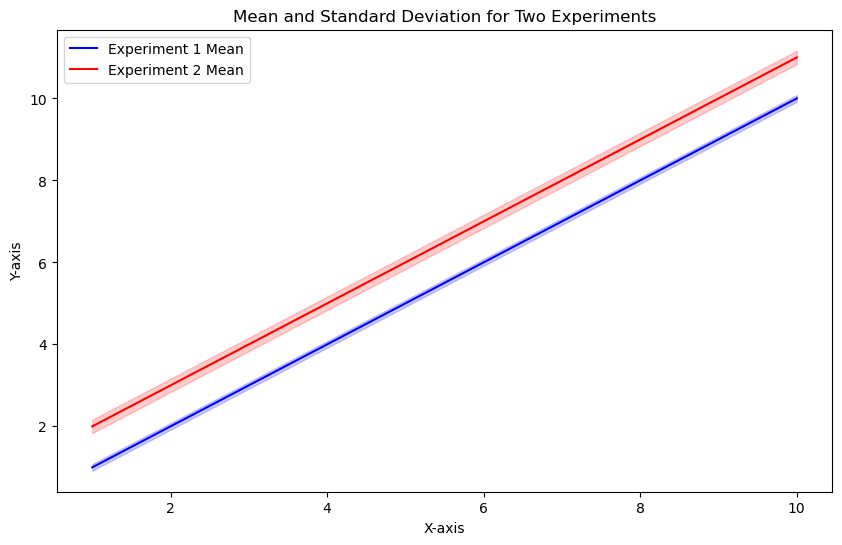

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Example data for 3 runs of 2 experiments (each run has 10 points)
experiment1 = np.array([
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    [1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1, 10.1],
    [0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9, 7.9, 8.9, 9.9]
])
experiment2 = np.array([
    [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    [2.2, 3.2, 4.2, 5.2, 6.2, 7.2, 8.2, 9.2, 10.2, 11.2],
    [1.8, 2.8, 3.8, 4.8, 5.8, 6.8, 7.8, 8.8, 9.8, 10.8]
])

# Compute means and standard deviations
mean1 = np.mean(experiment1, axis=0)
std1 = np.std(experiment1, axis=0)

mean2 = np.mean(experiment2, axis=0)
std2 = np.std(experiment2, axis=0)

# Create an x-axis
x = np.arange(1, 11)

# Plotting
plt.figure(figsize=(10, 6))

# Plot mean and standard deviation for experiment 1
plt.plot(x, mean1, label='Experiment 1 Mean', color='blue')
plt.fill_between(x, mean1 - std1, mean1 + std1, color='blue', alpha=0.2)

# Plot mean and standard deviation for experiment 2
plt.plot(x, mean2, label='Experiment 2 Mean', color='red')
plt.fill_between(x, mean2 - std2, mean2 + std2, color='red', alpha=0.2)

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Mean and Standard Deviation for Two Experiments')
plt.legend()

# Show plot
plt.show()

In [32]:
x_rebrac_1 = FetchPush['Step'][:1218]
x_rebrac_1

0          1
1          7
2         13
3         19
4         25
        ... 
1213    7279
1214    7285
1215    7291
1216    7297
1217    7303
Name: Step, Length: 1218, dtype: int64

In [30]:
len(x_rebrac_1)

1218

array([    1,     7,    13, ..., 14389, 14395, 14400])

In [103]:
x_rebrac_1 = FetchPush['Step']
y_rebrac_1 = FetchPush['rebrac-/home/nikisim/Mag_diplom/CORL/data/FetchPickAndPlaceDense.npy-d7c65c37 (Run set 3) - eval/is_succeess']#.dropna()
y_rebrac_2 = FetchPush['rebrac-/home/nikisim/Mag_diplom/CORL/data/FetchPickAndPlaceDense.npy-065ab774 (Run set 3) - eval/is_succeess']#.dropna()
y_rebrac_3 = FetchPush['rebrac-/home/nikisim/Mag_diplom/CORL/data/FetchPickAndPlaceDense.npy-f6aa2c99 (Run set 3) - eval/is_succeess']#.dropna()
y_iql = FetchPush['IQL-FetchPickAndPlace-1b88011e (Run set) - eval/is_succeess']#.dropna()

y_iql_100  = y_iql.drop([0])

dict1 = {
    'Step': x_rebrac_1.to_numpy()[:-1],
    'ReBRAC_1': y_rebrac_1.to_numpy()[:-1],
    'ReBRAC_2': y_rebrac_2.to_numpy()[:-1],
    'ReBRAC_3': y_rebrac_3.to_numpy()[:-1],
    'IQL': y_iql
}


In [110]:
len(dict1['IQL'])

406

In [54]:
# Load your data
FetchPush = pd.read_csv('/home/nikisim/Downloads/UR5_Fetch.csv')

# Extract the series you want to smooth
x_rebrac_1_1 = FetchPush['Step']
y_rebrac_1_1 = FetchPush['ReBRAC_test_old--c45ccef7 (Run set 2) - eval/is_succeess']#.dropna()

x_iql_100 = FetchPush['Step']
y_iql_100 = FetchPush['IQL_new_4-FetchPush_UR5-9b6f6ed6 (Run set 3) - eval/is_succeess']#.dropna()

In [55]:
FetchPush

,Step,FetchPush_new_8 (Run set) - eval/is_succeess,FetchPush_new_8 (Run set) - eval/is_succeess__MIN,FetchPush_new_8 (Run set) - eval/is_succeess__MAX,ReBRAC_test_old--c45ccef7 (Run set 2) - eval/is_succeess,ReBRAC_test_old--c45ccef7 (Run set 2) - eval/is_succeess__MIN,ReBRAC_test_old--c45ccef7 (Run set 2) - eval/is_succeess__MAX,IQL_new_4-FetchPush_UR5-9b6f6ed6 (Run set 3) - eval/is_succeess,IQL_new_4-FetchPush_UR5-9b6f6ed6 (Run set 3) - eval/is_succeess__MIN,IQL_new_4-FetchPush_UR5-9b6f6ed6 (Run set 3) - eval/is_succeess__MAX
0,0,0.00000,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.00000,0.00000,0.00000,0.1,0.1,0.1,NaN,NaN,NaN
2,2,0.01875,0.01875,0.01875,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.00625,0.00625,0.00625,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.13125,0.13125,0.13125,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1805,6979,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1806,6984,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1807,6989,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1808,6994,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [29]:
FetchPush['FetchPush_new_8 (Run set) - eval/is_succeess']

0       0.00000
1       0.00000
2       0.01875
3       0.00625
4       0.13125
         ...   
1805        NaN
1806        NaN
1807        NaN
1808        NaN
1809        NaN
Name: FetchPush_new_8 (Run set) - eval/is_succeess, Length: 1810, dtype: float64

In [56]:
import numpy as np
from scipy.interpolate import interp1d

original_array = FetchPush['FetchPush_new_8 (Run set) - eval/is_succeess'].dropna().to_numpy()

# Create an array of indices for the original array
original_indices = np.linspace(0, 1, num=len(original_array))

# Create an array of indices for the new array with 1810 elements
new_indices = np.linspace(0, 1, num=1810)

# Use interpolation to create the new array
# 'linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic' are some of the options
interpolation_method = 'quadratic'  # Choose the method you prefer
interpolator = interp1d(original_indices, original_array, kind=interpolation_method)

new_array = interpolator(new_indices)

In [64]:
dict1 = {
    'Step': x_rebrac_1_1.to_numpy(),
    'ReBRAC_400_400': y_rebrac_1_1.to_numpy(),
    'IQL': y_iql_100,
    'DDPG': new_array
}

In [90]:
df = pd.DataFrame(dict1)

In [91]:
df = df.dropna()

In [92]:
df.loc[0] = [0, 0.0, 0.0,0.0]

In [94]:
df.index = df.index + 1  # shifting index
df.sort_index(inplace=True) 

In [95]:
df

,Step,ReBRAC_400_400,IQL,DDPG
1,0.0,0.00,0.0,0.000000
35,34.0,0.76,0.0,0.127619
90,89.0,0.84,0.0,0.687726
145,144.0,0.90,0.0,0.611162
200,199.0,0.80,0.0,0.706595
...,...,...,...,...
1004,3059.0,0.76,0.0,0.691672
1019,3114.0,0.86,0.0,0.741390
1034,3169.0,0.86,0.0,0.644621
1049,3224.0,0.84,0.0,0.821238


In [47]:
# len(new_array)
len(x_rebrac_1_1)


1810

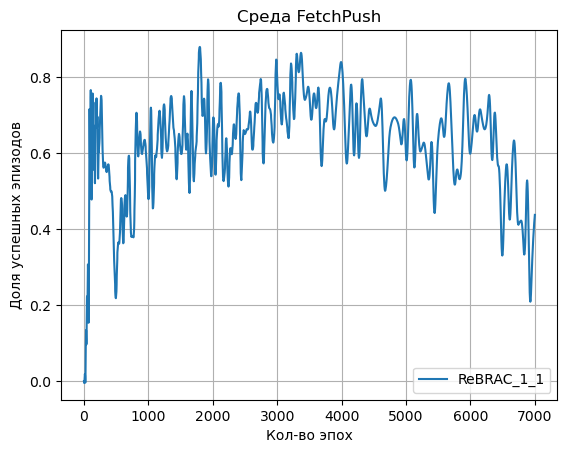

In [40]:
import matplotlib.pyplot as plt

plt.grid(linestyle='-')
plt.plot(x_rebrac_1_1,new_array)
# plt.plot(x_rebrac_10_10[:leng],smooth(y_rebrac_10_10.to_numpy(), radius=sm))
# plt.plot(df_cleaned['Step'],df_cleaned['IQL_100'])

# plt.ylim(0.75,1.01)
# plt.xlim(0.7,601.5)
plt.legend(['ReBRAC_1_1','IQL_100'], loc=4)
plt.title('Среда FetchPush')
plt.xlabel('Кол-во эпох')
plt.ylabel('Доля успешных эпизодов')
# plt.savefig('/home/nikisim/Mag_diplom/CORL/Images/FetchReach.png')
plt.show()

In [48]:
y_iql_100  = y_iql_100.drop([0])

In [49]:
dict1 = {
    'Step': x_rebrac_1_1.to_numpy()[:-1],
    'ReBRAC_400_400': y_rebrac_1_1.to_numpy()[:-1],
    'IQL': y_iql_100
}

In [50]:
df = pd.DataFrame(dict1)

In [51]:
df

,Step,ReBRAC_400_400,IQL
1,0,NaN,NaN
2,1,0.1,NaN
3,2,NaN,NaN
4,3,NaN,0.0
5,4,NaN,NaN
...,...,...,...
1805,6974,NaN,0.0
1806,6979,NaN,0.0
1807,6984,NaN,0.0
1808,6989,NaN,0.0


In [16]:
df_cleaned = df.dropna()
df_cleaned

,Step,ReBRAC_400_400,IQL
1,1,0.92,1.0
4,12,0.98,1.0
7,23,0.98,1.0
10,34,1.00,1.0
13,45,1.00,1.0
...,...,...,...
232,848,0.98,1.0
235,859,0.90,1.0
238,870,1.00,1.0
241,881,1.00,1.0


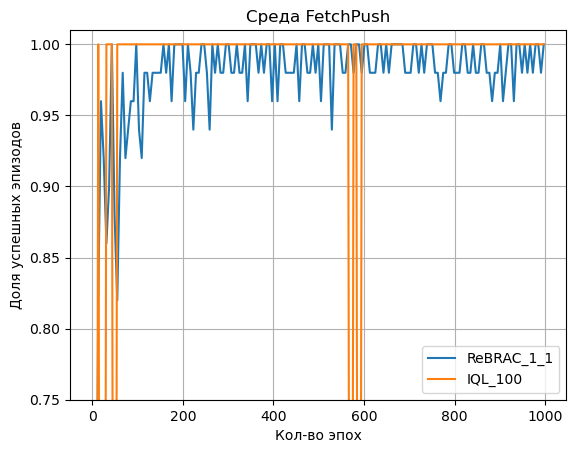

In [95]:
import matplotlib.pyplot as plt

plt.grid(linestyle='-')
plt.plot(df_cleaned['Step'],df_cleaned['ReBRAC_1_1'])
# plt.plot(x_rebrac_10_10[:leng],smooth(y_rebrac_10_10.to_numpy(), radius=sm))
plt.plot(df_cleaned['Step'],df_cleaned['IQL_100'])

plt.ylim(0.75,1.01)
# plt.xlim(0.7,601.5)
plt.legend(['ReBRAC_1_1','IQL_100'], loc=4)
plt.title('Среда FetchPush')
plt.xlabel('Кол-во эпох')
plt.ylabel('Доля успешных эпизодов')
# plt.savefig('/home/nikisim/Mag_diplom/CORL/Images/FetchReach.png')
plt.show()

In [31]:
leng = y_rebrac_1_1.shape[0]

In [32]:
def smooth(smoothing_weight, viewport_scale, x_values, y_values):
    # Initialize variables
    last_y = y_values.iloc[0] if len(y_values) > 0 else np.nan
    debias_weight = 0
    ema_values = []

    # Calculate the range of x (if needed for scaling)
    range_of_x = x_values.max() - x_values.min()

    # Calculate EMA with variable intervals
    for index, y_point in enumerate(y_values):
        prev_x = x_values.iloc[index - 1] if index > 0 else x_values.iloc[0]
        change_in_x = ((x_values.iloc[index] - prev_x) / range_of_x) * viewport_scale
        smoothing_weight_adj = np.power(smoothing_weight, change_in_x)
        
        last_y = last_y * smoothing_weight_adj + y_point
        debias_weight = debias_weight * smoothing_weight_adj + 1
        ema_value = last_y / debias_weight
        ema_values.append(ema_value)
    
    return ema_values

In [15]:
import numpy as np

In [33]:
smooth_rebrac = smooth(0.99, 1, x_rebrac_1_1, y_rebrac_1_1)

In [36]:
x_rebrac_1_1[:leng]

0         1
1         4
2         7
3         9
4        13
       ... 
359    1153
360    1159
361    1165
362    1171
363    1177
Name: Step, Length: 364, dtype: int64

In [34]:
len(smooth_rebrac)

364

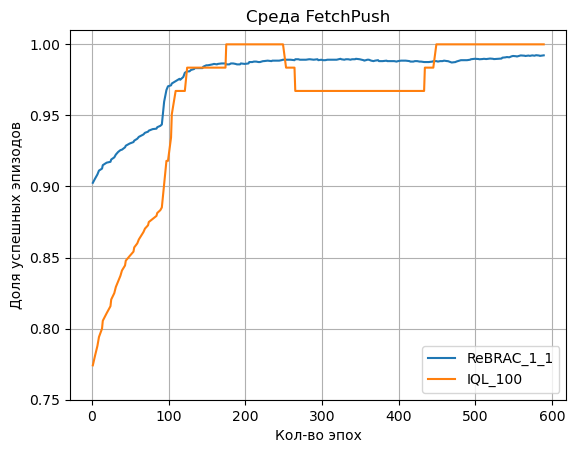

In [7]:
import matplotlib.pyplot as plt

sm = 30
plt.grid(linestyle='-')
plt.plot(x_rebrac_1_1[:leng],smooth(y_rebrac_1_1.to_numpy(), radius=sm))
# plt.plot(x_rebrac_10_10[:leng],smooth(y_rebrac_10_10.to_numpy(), radius=sm))
plt.plot(x_iql_100[:leng],smooth(y_iql_100[:leng].to_numpy(), radius=sm))

plt.ylim(0.75,1.01)
# plt.xlim(0.7,601.5)
plt.legend(['ReBRAC_1_1','IQL_100'], loc=4)
plt.title('Среда FetchPush')
plt.xlabel('Кол-во эпох')
plt.ylabel('Доля успешных эпизодов')
# plt.savefig('/home/nikisim/Mag_diplom/CORL/Images/FetchReach.png')
plt.show()



In [10]:
data = [[x, y] for (x, y) in zip(y_iql_100[:leng].to_numpy(), smooth(x_iql_100.to_numpy(), radius=99))]

In [11]:
import wandb
import random
import math

# Start a new run
run = wandb.init(project='custom-charts6')
offset = random.random()

# At each time step in the model training loop
#for run_step in range(20):

# Set up data to log in custom charts
# data = []
# for i in range(100):
#   data.append([i, random.random() + math.log(1 + i) + offset + random.random()])

# Create a table with the columns to plot
table = wandb.Table(data=data, columns=["epoch", "success_rate"])

# Use the table to populate various custom charts
line_plot = wandb.plot.line(table, x='epoch', y='success_rate', title='FetchReach')

# Log custom tables, which will show up in customizable charts in the UI
wandb.log({'line_1': line_plot, 
            })

# Finally, end the run. We only need this ine in Jupyter notebooks.
run.finish()

In [12]:
data = [[x, y] for (x, y) in zip(y_rebrac_1_1[:leng].to_numpy(), smooth(x_rebrac_1_1.to_numpy(), radius=99))]

In [14]:
import wandb
import random
import math

# Start a new run
run = wandb.init(project='custom-charts3')
offset = random.random()
wandb.init(
    name="IQL",
    id="IQL"
)

# At each time step in the model training loop
for run_step in range(20):

    # Create a table with the columns to plot
    table = wandb.Table(data=data[:10], columns=["epoch", "success_rate"])

    # Use the table to populate various custom charts
    line_plot = wandb.plot.line(table, x='epoch', y='success_rate', title='FetchReach')

    # Log custom tables, which will show up in customizable charts in the UI
    wandb.log({'line_1': line_plot, 
                })

# Finally, end the run. We only need this ine in Jupyter notebooks.
run.finish()

wandb: ERROR Control-C detected -- Run data was not synced
